In [ ]:
import sys, pathlib
import matplotlib.pyplot as plt

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

In [13]:
from src.dataset import build_dataset
from src.config import TARGET_COL, FEATURE_COLS

df_feat = build_dataset()  # maintenant ça merge EURUSD + VIX + taux + SP500 + dollar index

print("Shape:", df_feat.shape)
print("Période:", df_feat["date"].min().date(), "→", df_feat["date"].max().date())
df_feat.head()


Shape: (2543, 38)
Période: 2015-12-23 → 2025-10-23


,date,open,high,low,close,vix,dgs2,dgs10,dtwexbgs,sp500,...,dow_cos,vix_lag1,dgs2_lag1,dgs10_lag1,term_spread,term_spread_lag1,dtwexbgs_ret_lag1,sp500_ret_lag1,close_tomorrow,y_up
0,2015-12-23,1.09510,1.09530,1.08707,1.09048,15.57,1.01,2.27,113.1847,2064.29,...,-0.222521,16.60,0.99,2.24,1.26,1.25,-0.001793,0.008817,1.09518,1
1,2015-12-24,1.09050,1.09658,1.09050,1.09518,15.74,1.03,2.25,113.0496,2060.99,...,-0.900969,15.57,1.01,2.27,1.22,1.26,-0.000232,0.012418,1.09750,1
2,2015-12-28,1.09625,1.09925,1.09563,1.09750,16.91,1.05,2.24,113.0461,2056.50,...,1.000000,15.74,1.03,2.25,1.19,1.22,-0.001194,-0.001599,1.09229,0
3,2015-12-29,1.09754,1.09917,1.08999,1.09229,16.08,1.09,2.32,113.1664,2078.36,...,0.623490,16.91,1.05,2.24,1.23,1.19,-0.000031,-0.002179,1.09260,1
4,2015-12-30,1.09247,1.09437,1.09028,1.09260,17.29,1.08,2.31,113.4707,2063.36,...,-0.222521,16.08,1.09,2.32,1.23,1.23,0.001064,0.010630,1.08605,0


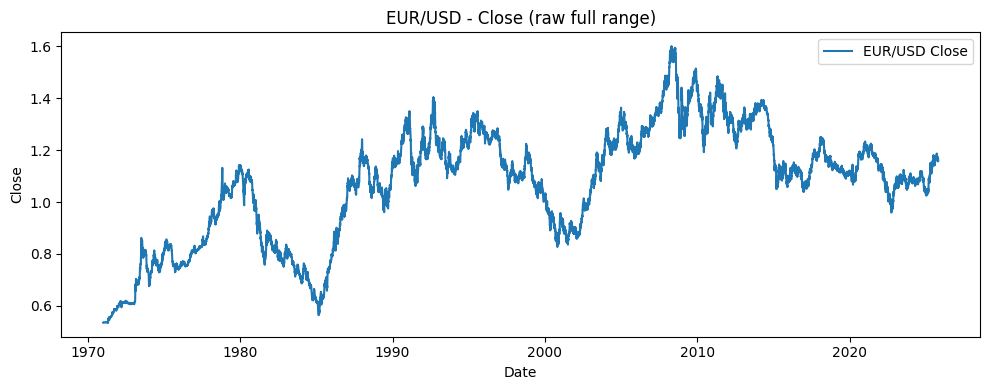

In [22]:
plt.figure(figsize=(10,4))
plt.plot(df_raw["date"], df_raw["close"], label="EUR/USD Close")
plt.title("EUR/USD - Close (raw full range)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()


Return moyen: 3.321491206172191e-05
Return std  : 0.004630968495810566


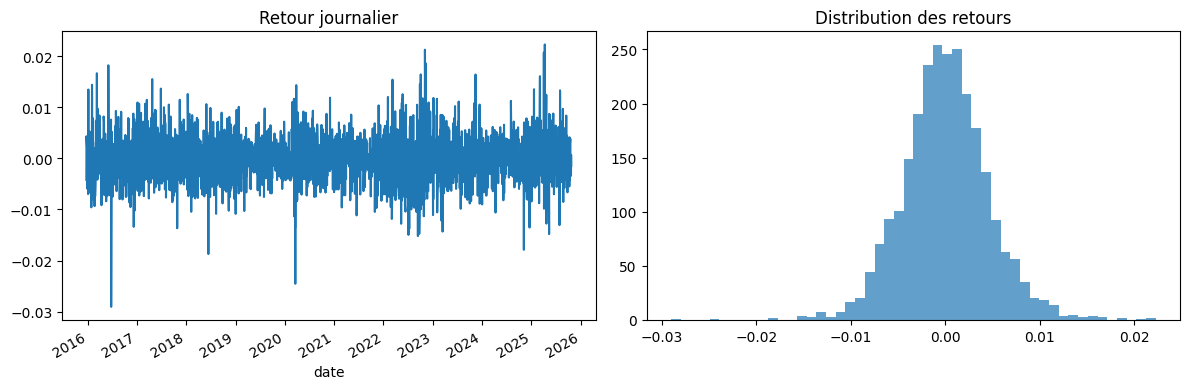

In [20]:
print("Return moyen:", df_feat["ret"].mean())
print("Return std  :", df_feat["ret"].std())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_feat.set_index("date")["ret"].plot(ax=axes[0], title="Retour journalier")
axes[1].hist(df_feat["ret"].dropna(), bins=50, alpha=0.7)
axes[1].set_title("Distribution des retours")
plt.tight_layout()
plt.show()


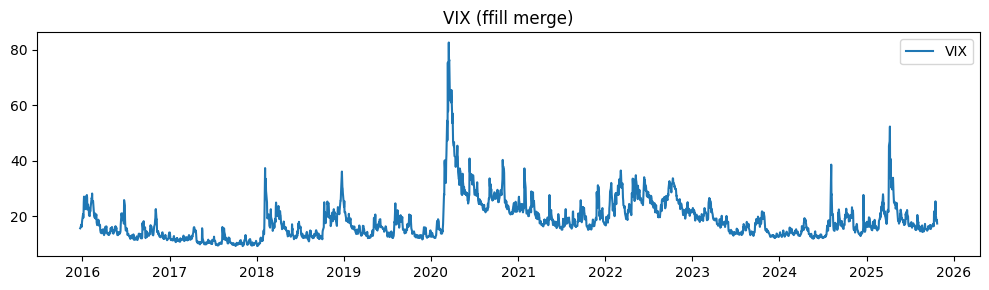

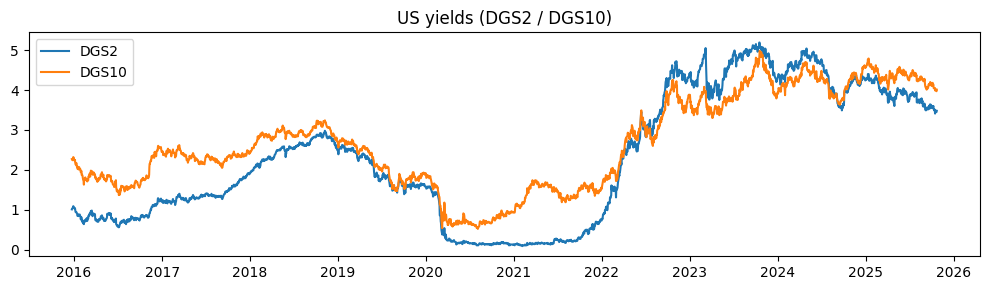

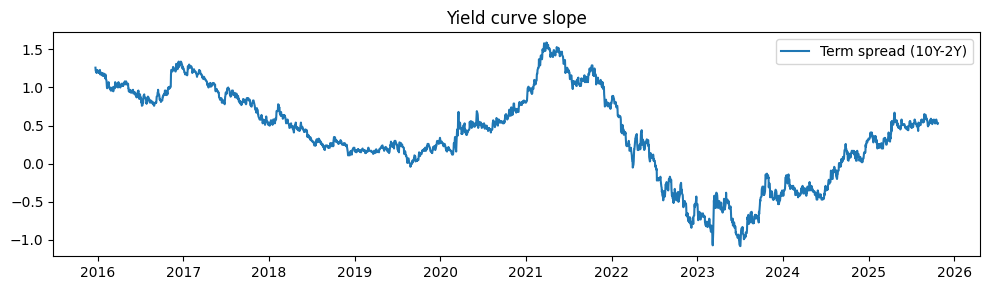

In [5]:
# VIX
plt.figure(figsize=(10, 3))
plt.plot(df_feat["date"], df_feat["vix"], label="VIX")
plt.title("VIX (ffill merge)")
plt.legend()
plt.tight_layout()
plt.show()

# Taux US + spread
plt.figure(figsize=(10, 3))
plt.plot(df_feat["date"], df_feat["dgs2"], label="DGS2")
plt.plot(df_feat["date"], df_feat["dgs10"], label="DGS10")
plt.title("US yields (DGS2 / DGS10)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(df_feat["date"], df_feat["term_spread"], label="Term spread (10Y-2Y)")
plt.title("Yield curve slope")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
cols_show = ["date", "close", "vix", "dgs2", "dgs10", "dtwexbgs", "sp500"] + FEATURE_COLS + [TARGET_COL]
cols_show = [c for c in cols_show if c in df_feat.columns]

df_feat[cols_show].head(10)


,date,close,vix,dgs2,dgs10,dtwexbgs,sp500,ret_lag1,ret_lag2,ret_lag3,...,macd_hist,dow_sin,dow_cos,vix_lag1,dgs2_lag1,dgs10_lag1,term_spread_lag1,dtwexbgs_ret_lag1,sp500_ret_lag1,y_up
0,2015-12-23,1.09048,15.57,1.01,2.27,113.1847,2064.29,0.003804,0.003680,0.003221,...,0.001087,0.974928,-0.222521,16.60,0.99,2.24,1.25,-0.001793,0.008817,1
1,2015-12-24,1.09518,15.74,1.03,2.25,113.0496,2060.99,-0.004219,0.003804,0.003680,...,0.001092,0.433884,-0.900969,15.57,1.01,2.27,1.26,-0.000232,0.012418,1
2,2015-12-28,1.09750,16.91,1.05,2.24,113.0461,2056.50,0.004310,-0.004219,0.003804,...,0.001170,0.000000,1.000000,15.74,1.03,2.25,1.22,-0.001194,-0.001599,0
3,2015-12-29,1.09229,16.08,1.09,2.32,113.1664,2078.36,0.002118,0.004310,-0.004219,...,0.000806,0.781831,0.623490,16.91,1.05,2.24,1.19,-0.000031,-0.002179,1
4,2015-12-30,1.09260,17.29,1.08,2.31,113.4707,2063.36,-0.004747,0.002118,0.004310,...,0.000534,0.974928,-0.222521,16.08,1.09,2.32,1.23,0.001064,0.010630,0
5,2015-12-31,1.08605,18.21,1.06,2.27,113.3429,2043.94,0.000284,-0.004747,0.002118,...,-0.000104,0.433884,-0.900969,17.29,1.08,2.31,1.23,0.002689,-0.007217,0
6,2016-01-04,1.08296,20.70,1.02,2.24,114.1595,2012.66,-0.005995,0.000284,-0.004747,...,-0.000718,0.000000,1.000000,18.21,1.06,2.27,1.21,-0.001126,-0.009412,0
7,2016-01-05,1.07539,19.34,1.04,2.25,114.2649,2016.71,-0.002845,-0.005995,0.000284,...,-0.001568,0.781831,0.623490,20.70,1.02,2.24,1.22,0.007205,-0.015304,1
8,2016-01-06,1.07768,20.59,0.99,2.18,114.6177,1990.26,-0.006990,-0.002845,-0.005995,...,-0.001889,0.974928,-0.222521,19.34,1.04,2.25,1.21,0.000923,0.002012,1
9,2016-01-07,1.09218,24.99,0.96,2.16,114.6516,1943.09,0.002129,-0.006990,-0.002845,...,-0.001078,0.433884,-0.900969,20.59,0.99,2.18,1.19,0.003088,-0.013115,0


In [7]:
from src.modeling import train_test_split_time

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Target balance:", df_feat[TARGET_COL].value_counts(normalize=True).round(3))


Train: (2034, 22) | Test: (509, 22)
Target balance: y_up
1    0.504
0    0.496
Name: proportion, dtype: float64


In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
pred = dummy.predict(X_test)
print("=== Dummy (most_frequent) ===")
print("Accuracy:", round(accuracy_score(y_test, pred), 3))

dummy_s = DummyClassifier(strategy="stratified", random_state=0)
dummy_s.fit(X_train, y_train)
proba = dummy_s.predict_proba(X_test)[:, 1]
print("ROC-AUC (stratified):", round(roc_auc_score(y_test, proba), 3))


=== Dummy (most_frequent) ===
Accuracy: 0.501
ROC-AUC (stratified): 0.493


In [9]:
from src.modeling import build_logreg_pipeline
from src.evaluation import evaluate_classifier

model = build_logreg_pipeline()
model.fit(X_train, y_train)

evaluate_classifier(model, X_train, y_train, X_test, y_test, name="LogReg baseline")


=== LogReg baseline ===
Accuracy: 0.511
ROC-AUC : 0.513
Confusion matrix:
 [[193  61]
 [188  67]]

Classification report:
               precision    recall  f1-score   support

           0      0.507     0.760     0.608       254
           1      0.523     0.263     0.350       255

    accuracy                          0.511       509
   macro avg      0.515     0.511     0.479       509
weighted avg      0.515     0.511     0.479       509



(0.5108055009823183, 0.5127064999228037)

“VIX is used as external risk sentiment proxy. We use only lagged VIX to avoid leakage.”